In [1]:
"""
Source: https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/
"""

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict
import datetime

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Colour_Palette = ['#01BEFE', '#FF7D00', '#FFDD00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(Colour_Palette))

tqdm.pandas()


In [2]:
torch.cuda.is_available()

False

                     INV2  TEMP  HUM
Date                                
2024-06-04 02:00:00   0.0   0.0  0.0
2024-06-04 02:15:00   0.0   0.0  0.0
2024-06-04 02:30:00   0.0   0.0  0.0
2024-06-04 02:45:00   0.0   0.0  0.0
2024-06-04 03:00:00   0.0   0.0  0.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9576 entries, 2024-06-04 02:00:00 to 2024-09-11 19:45:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   INV2    9576 non-null   float64
 1   TEMP    9576 non-null   float64
 2   HUM     9576 non-null   float64
dtypes: float64(3)
memory usage: 299.2 KB
None


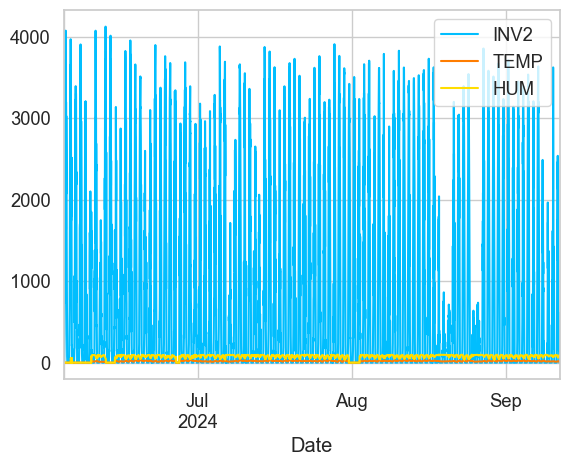

In [3]:

# Normal data set
#df = pd.read_csv("data.csv", delimiter=";")
#df["Date"] = pd.to_datetime(df['Date'], dayfirst=True)

# Data set over two months
df = pd.read_csv("data/all-data-15min.csv", delimiter=";")
df["Date"] = pd.to_datetime(df['Date'], dayfirst=True, format="%Y-%m-%d %H:%M:%S")

#df["Date"] = df['Date'].astype('int64').astype(int)
#df['Date'] = df['Date'].div(10**9)

# Set Index
df.set_index("Date", inplace=True)

# Remove Temp and Humidity Column for test purpose
# df = df.drop(columns=['TEMP', 'HUM'])

# Inspect the data
print(df.head())
print(df.info())
df.plot()
plt.show()


In [4]:
dataset_train = train_data.iloc[:,:]
dataset_train

NameError: name 'train_data' is not defined

In [4]:
import math
from sklearn.preprocessing import MinMaxScaler

# Train test split
training_data_len = math.ceil(len(df) * .9) # (.8)
print(training_data_len)

# Splitting the dataset
# train_data = df[:training_data_len].iloc[:, :1]
# test_data = df[training_data_len:].iloc[:, :1]
# Splitting the dataset V2
train_data = df[:training_data_len].iloc[:, :3]
test_data  = df[training_data_len:].iloc[:, :3]

# Use second column here --> instead of "Date" use "Open", which stands for INV2 power
# train_data = df[:training_data_len].iloc[:, 1:2]
# test_data = df[training_data_len:].iloc[:, 1:2]

print(train_data.shape, test_data.shape)

# Selecting Open Price values
dataset_train = train_data.INV2.values
#dataset_train = train_data.iloc[:,:]
# dataset_train = df
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1)) # (-1,1) --> n-rows, 1 col
print(dataset_train.shape)

# Selecting Open Price values
dataset_test = test_data.INV2.values
#dataset_test = test_data.iloc[:,:]
# dataset_test = df
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)

scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

# Normalizing values between 0 and 1
scaled_test = scaler.transform(dataset_test)
print(scaled_test[:5])

# Create sequences and labels for training data
sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])  # Predicting the value right after the sequence
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)


8619
(8619, 3) (957, 3)
(8619, 1)
(957, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
torch.Size([8569, 50, 1]) torch.Size([8569, 1])
torch.Size([927, 30, 1]) torch.Size([927, 1])


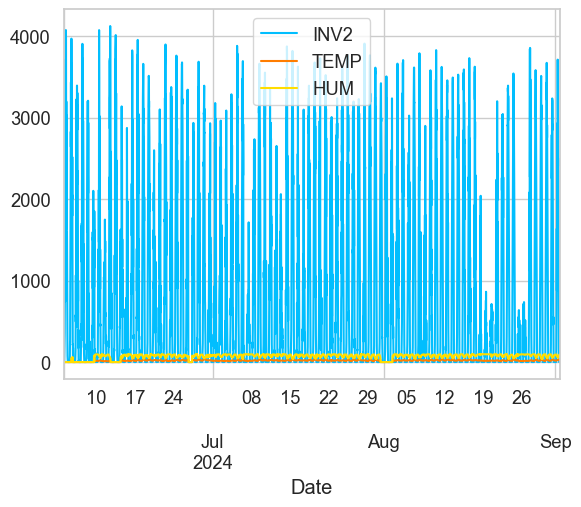

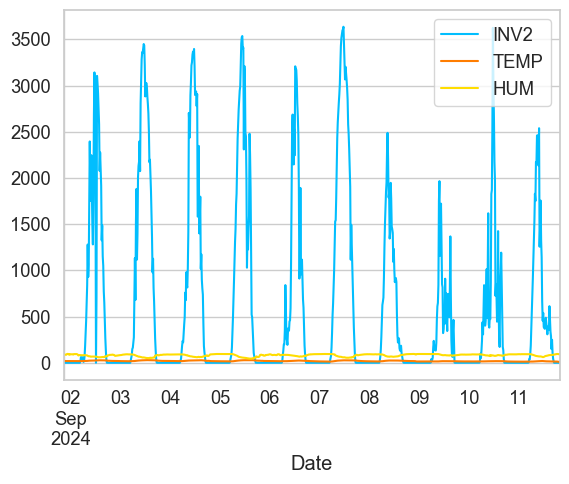

In [5]:
train_data.plot()
test_data.plot()
plt.show()

cpu
Start epochs...
Epoche: 1
Epoche: 2
Epoche: 3
Epoche: 4
Epoche: 5
Epoche: 6
Epoche: 7
Epoche: 8
Epoche: 9
Epoche: 10
Epoch [10/10] - Training Loss: 0.0051, Test Loss: 0.0046
done


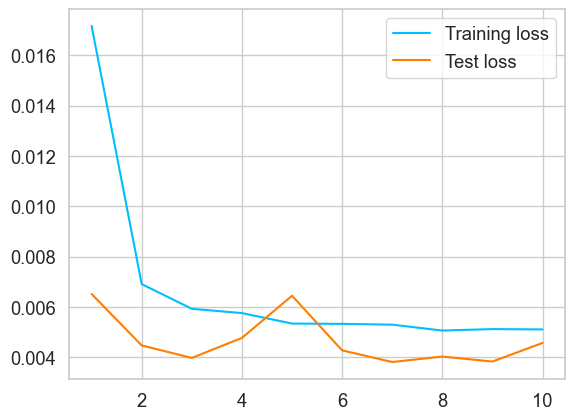

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = 1
num_layers = 3  # Increased number of layers (3)
hidden_size = 128  # Increased number of hidden units (128)
output_size = 1
dropout = 0.2  # Added dropout for regularization

model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0)  # Learning rate

batch_size = 32*1  # Adjusted batch size (32)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 10  # Increased number of epochs 100
train_hist = []
test_hist = []

print("Start epochs...")
for epoch in range(num_epochs):
    predictions_test_all = [] # added
    print(f"Epoche: {epoch+1}")
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            predictions_test_cpu = predictions_test.cpu().numpy()[0, 0] # added
            predictions_test_all.append(predictions_test_cpu)           # added
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


        
        
# Save model
model_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
torch.save(model.state_dict(), f"{model_time}_model-autosave.pytorch")

        
print(f"done")



x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()


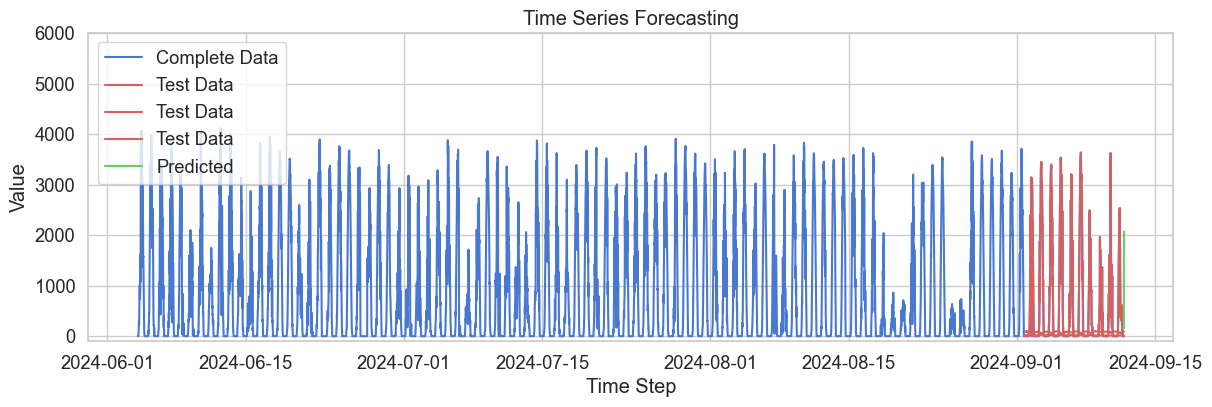

RMSE: 0.0676
R² Score: 0.9230
                         Predict
Date                            
2024-09-11 19:46:00   151.390808
2024-09-11 19:47:00   304.491943
2024-09-11 19:48:00   453.552704
2024-09-11 19:49:00   598.472595
2024-09-11 19:50:00   737.419434
2024-09-11 19:51:00   870.422913
2024-09-11 19:52:00   998.626892
2024-09-11 19:53:00  1123.002441
2024-09-11 19:54:00  1244.055298
2024-09-11 19:55:00  1361.087769
2024-09-11 19:56:00  1472.880615
2024-09-11 19:57:00  1578.552734
2024-09-11 19:58:00  1676.151855
2024-09-11 19:59:00  1764.200806
2024-09-11 20:00:00  1841.930420
2024-09-11 20:01:00  1908.680542
2024-09-11 20:02:00  1964.614624
2024-09-11 20:03:00  2009.328003
2024-09-11 20:04:00  2042.682129
2024-09-11 20:05:00  2064.655029
2024-09-11 20:06:00  2075.123291
2024-09-11 20:07:00  2073.922119
2024-09-11 20:08:00  2060.785156
2024-09-11 20:09:00  2035.392578
2024-09-11 20:10:00  1997.453857
2024-09-11 20:11:00  1946.801147
2024-09-11 20:12:00  1883.485352
2024-09-11 20

In [7]:
num_forecast_steps = 30*1 # (30)
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

forecasted_values = []
model.eval()
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(1, unit='m'), periods=num_forecast_steps, freq="1min") # add 1 min steps to the df

forecasted = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()
predicted = pd.DataFrame()
predicted.insert(0, "Date", future_dates)
predicted.insert(1, "Predict", forecasted)
predicted.set_index("Date", inplace=True)

plt.rcParams['figure.figsize'] = [14, 4]

# Plot complete data
plt.plot(df.index[:], df.INV2, label="Complete Data", color="b")

# Plot training data
# plt.plot(train_data.index[:], train_data[:], label="Training Data", color="g")

# Plot test data
plt.plot(test_data.index[:], test_data[:], label="Test Data", color="r")

# Plot predicted data
plt.plot(predicted.index[:], predicted[:], label='Predicted', color='g')

# Misc Plots
# plt.plot(test_data.index[-num_forecast_steps:], test_data[-num_forecast_steps:], label='actual values', color='green')
# plt.plot(test_data.index[-1:].append(future_dates), np.concatenate([test_data[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()]), label='forecasted values', color='red')


plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
plt.ylim(-100,6000)
plt.show()

# Evaluate the model and calculate RMSE and R² score
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')
print(predicted)

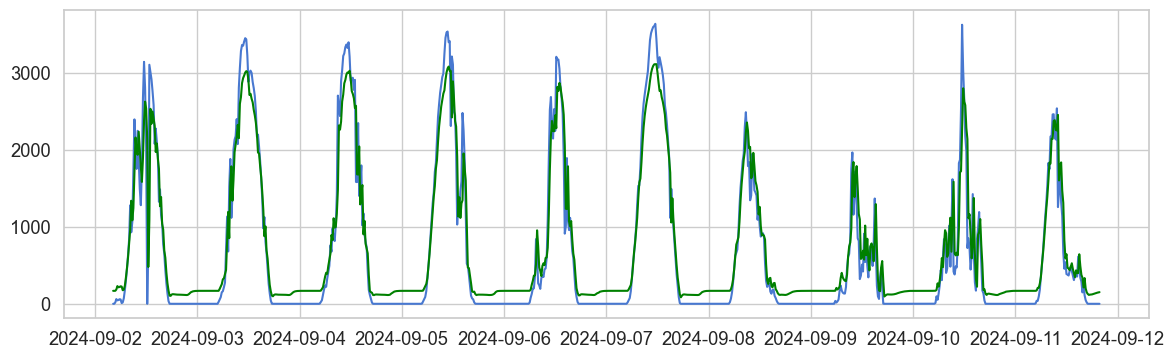

In [8]:
test_predictions_all = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
#test_predictions_all = test_predictions_all.reshape(3,-1)

plt.plot(test_data.index[30:], test_data.INV2[30:], label="Test Data", color="b")
plt.plot(test_data.index[30:], test_predictions_all, label="Test Data_predicted", color='green')
plt.show()

dPred = test_data.INV2[30:]- test_predictions_all

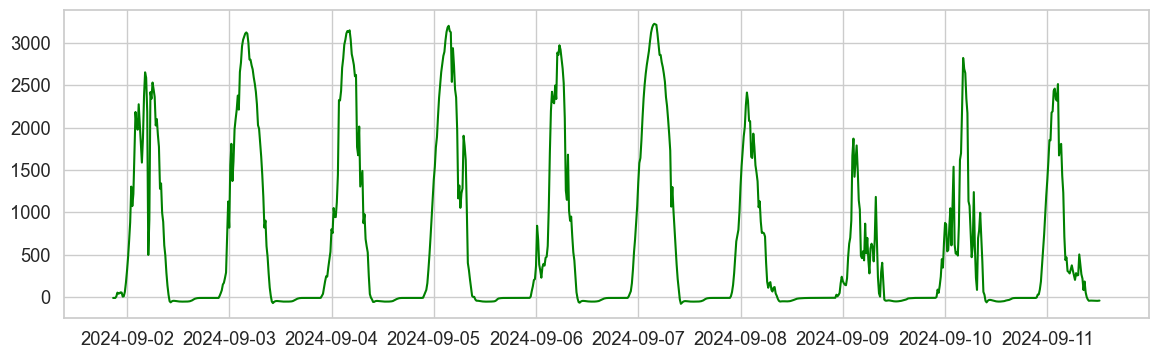

<AxesSubplot: xlabel='Date'>

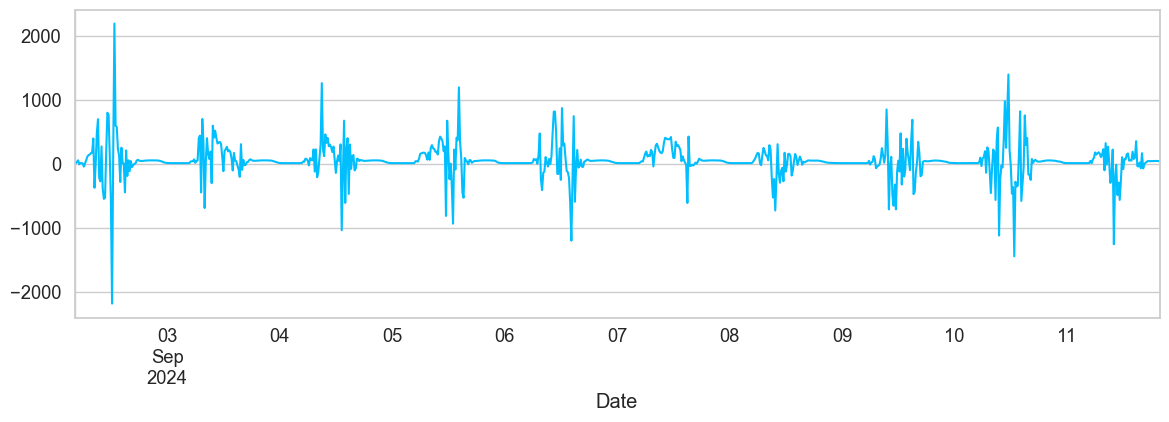

In [10]:
plt.plot(test_data.index[0:-num_forecast_steps], test_predictions_all, label="TestDate_predicted", color='green')
plt.show()
dPred.plot()

In [11]:
forecasted_values

[-0.010233243,
 -0.019920707,
 -0.029596277,
 -0.03950793,
 -0.04962696,
 -0.059934326,
 -0.07040747,
 -0.08101841,
 -0.09164695,
 -0.10220573,
 -0.11254019,
 -0.122267716,
 -0.13126026,
 -0.13932998,
 -0.14622727,
 -0.15177165,
 -0.15566622,
 -0.15781902,
 -0.15815209,
 -0.15665369,
 -0.15338914,
 -0.14849232,
 -0.14215992,
 -0.13463007,
 -0.1261587,
 -0.116996184,
 -0.10736821,
 -0.09746241,
 -0.08742157,
 -0.07734274]

In [12]:
test_predictions_all[1]

-10.684758

In [11]:
# Combine everything in a dataframe
df_final = df.copy(deep=True)
df_final['Predict'] = df_final["INV2"]
# df_final.insert(1, "Predict", forecasted)

len_df = len(df.index)
for idx,date in enumerate(predicted.index):
    df_final.loc[len_df+idx] = ['Predict'] + 1
    print(date)

TypeError: can only concatenate list (not "int") to list

In [ ]:
predicted.to_csv("predicted.csv", sep=";")

In [ ]:
df_final

In [ ]:
predicted

In [ ]:
predictions

In [ ]:
(last_date)

In [ ]:
predicted[-30:]

In [ ]:
batch_X

In [ ]:
model.plot_prediction()